In [2]:
# --- Load libraries and data ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

# Paths (adjust if your files are in a different location)
train_path = 'train.csv'
test_path = 'test.csv'

# Load data
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
print('Train shape:', train.shape)
print('Test shape:', test.shape)
display(train.head().T)

Train shape: (1460, 81)
Test shape: (1459, 80)


,0,1,2,3,4
Id,1,2,3,4,5
MSSubClass,60,20,60,70,60
MSZoning,RL,RL,RL,RL,RL
LotFrontage,65.0,80.0,68.0,60.0,84.0
LotArea,8450,9600,11250,9550,14260
...,...,...,...,...,...
MoSold,2,5,9,2,12
YrSold,2008,2007,2008,2006,2008
SaleType,WD,WD,WD,WD,WD
SaleCondition,Normal,Normal,Normal,Abnorml,Normal


In [7]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000



### Q1: What is the target variable in this dataset, and what type of machine learning problem does it represent? ion

In [8]:
print("Target variable: SalePrice (regression problem)")

Target variable: SalePrice (regression problem)


### Q2: How many features (columns) and observations (rows) are in the training set?


In [9]:
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (1460, 81)
Test shape: (1459, 80)


### Q3. Identify the data types (numeric, categorical) of the features. How many are categorical vs. numeric?  

In [10]:
numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = train.select_dtypes(exclude=[np.number]).columns.tolist()
print(f"Numeric cols: {len(numeric_cols)}, Categorical cols: {len(cat_cols)}")

Numeric cols: 38, Categorical cols: 43


### Q4. Which features have missing values? What percentage of data is missing for the top 3 features with the most missing values?

In [11]:
miss = train.isnull().sum().sort_values(ascending=False)
miss_pct = (miss / len(train) * 100).round(2)
miss_df = pd.DataFrame({'missing_count': miss, 'missing_percent': miss_pct})
display(miss_df[miss_df['missing_count']>0].head(12))

,missing_count,missing_percent
PoolQC,1453,99.52
MiscFeature,1406,96.30
Alley,1369,93.77
Fence,1179,80.75
MasVnrType,872,59.73
FireplaceQu,690,47.26
LotFrontage,259,17.74
GarageQual,81,5.55
GarageFinish,81,5.55
GarageType,81,5.55


### Q5. Plot the distribution of the target variable `SalePrice`. Is it normally distributed? If not, how can you transform it to reduce skewness?

SalePrice skewness: 1.8828757597682129
log1p(SalePrice) skewness: 0.12134661989685333


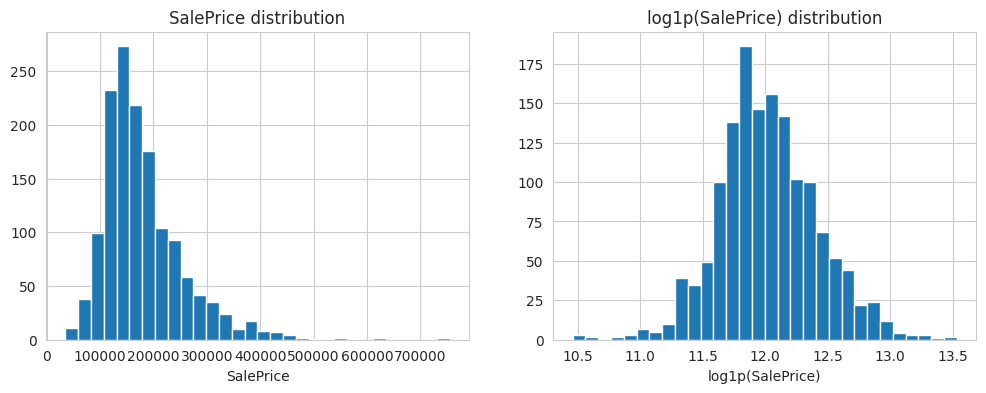

In [12]:
sale = train['SalePrice'].dropna()
print('SalePrice skewness:', sale.skew())
print('log1p(SalePrice) skewness:', np.log1p(sale).skew())

plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.hist(sale, bins=30); plt.title('SalePrice distribution'); plt.xlabel('SalePrice')
plt.subplot(1,2,2); plt.hist(np.log1p(sale), bins=30); plt.title('log1p(SalePrice) distribution'); plt.xlabel('log1p(SalePrice)')
plt.show()

### Q6. How would you handle missing values in `LotFrontage`, `Alley`, and `GarageYrBlt`? Justify your strategy for each.  

In [13]:
# Example imputation strategies
df = train.copy()

# LotFrontage: median per Neighborhood, fallback to overall median
df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].median())

# Alley: missing -> NoAlley
df['Alley'] = df['Alley'].fillna('NoAlley')

# Garage: HasGarage flag; impute GarageYrBlt with YearBuilt where missing
df['HasGarage'] = df['GarageType'].notnull().astype(int)
df.loc[df['HasGarage']==0, 'GarageYrBlt'] = np.nan
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(df['YearBuilt'])

display(df[['LotFrontage','Alley','GarageYrBlt','HasGarage']].head())

,LotFrontage,Alley,GarageYrBlt,HasGarage
0,65.0,NoAlley,2003.0,1
1,80.0,NoAlley,1976.0,1
2,68.0,NoAlley,2001.0,1
3,60.0,NoAlley,1998.0,1
4,84.0,NoAlley,2000.0,1


****

### Q7. Many categorical variables (e.g., `MSZoning`, `Utilities`) contain text labels. How will you encode them for use in a regression model?  

In [14]:
import pandas as pd

# Load your training data
df = pd.read_csv("train.csv")

# Identify all categorical (object) columns
cat_cols = df.select_dtypes(include=['object']).columns
print("Categorical Columns:", list(cat_cols))

# Fill missing values in categorical columns
df[cat_cols] = df[cat_cols].fillna("Missing")

# Convert categorical → numeric using One-Hot Encoding
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

print("Shape after encoding:", df_encoded.shape)
df_encoded.head(10)




Categorical Columns: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
Shape after encoding: (1460, 262)


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,False,False,False,False,True,False,False,False,True,False
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,False,False,False,False,True,False,False,False,True,False
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,False,False,False,False,True,False,False,False,True,False
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,False,False,False,False,True,False,False,False,False,False
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,False,False,False,False,True,False,False,False,True,False
5,6,50,85.0,14115,5,5,1993,1995,0.0,732,...,False,False,False,False,True,False,False,False,True,False
6,7,20,75.0,10084,8,5,2004,2005,186.0,1369,...,False,False,False,False,True,False,False,False,True,False
7,8,60,NaN,10382,7,6,1973,1973,240.0,859,...,False,False,False,False,True,False,False,False,True,False
8,9,50,51.0,6120,7,5,1931,1950,0.0,0,...,False,False,False,False,True,False,False,False,False,False
9,10,190,50.0,7420,5,6,1939,1950,0.0,851,...,False,False,False,False,True,False,False,False,True,False


### Q8. Are there any redundant or highly correlated features? Use a correlation heatmap to identify and suggest which ones to drop.  

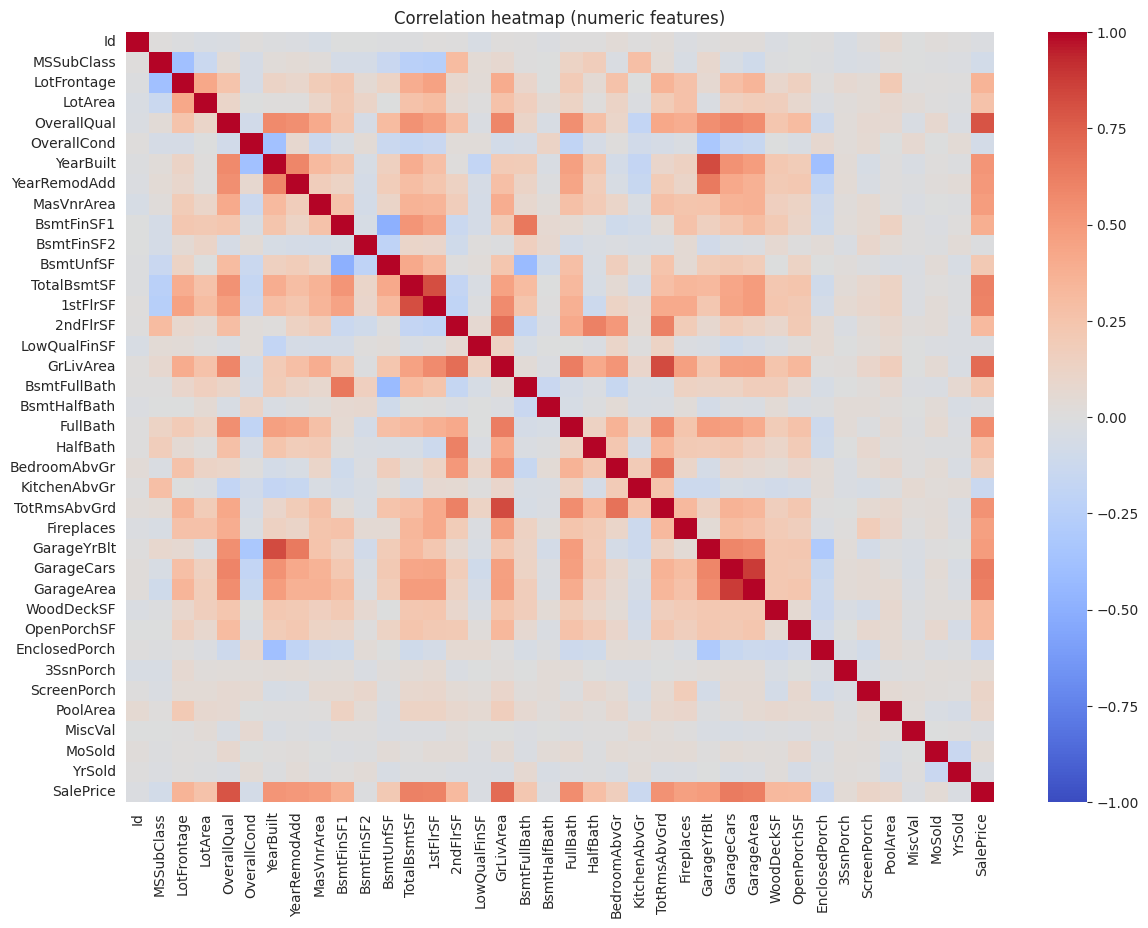

[('GarageCars', 'GarageArea', np.float64(0.882475414281462))]

In [15]:
num = train.select_dtypes(include=[np.number])
corr = num.corr()
plt.figure(figsize=(14,10))
sns.heatmap(corr, cmap='coolwarm', center=0, vmax=1, vmin=-1)
plt.title('Correlation heatmap (numeric features)')
plt.show()

# Identify highly correlated pairs
high_pairs = []
cols = corr.columns
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        if abs(corr.values[i,j]) > 0.85:
            high_pairs.append((cols[i], cols[j], corr.values[i,j]))
high_pairs[:20]


### Q9. Create a new feature called `TotalLivingArea` = `GrLivArea` + `TotalBsmtSF`. Why might this be useful?  


In [16]:
import pandas as pd

# 1. Loading Files
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# 2. TotalLivingArea feature defining
train['TotalLivingArea'] = train['GrLivArea'] + train['TotalBsmtSF']
test['TotalLivingArea'] = test['GrLivArea'] + test['TotalBsmtSF']

print("Data successfully loaded and 'TotalLivingArea' feature created.")


# 3. For verification:
print("First 5 values of the new feature in the training data:")
print(train[['GrLivArea', 'TotalBsmtSF', 'TotalLivingArea']].head())


train.head()

Data successfully loaded and 'TotalLivingArea' feature created.
First 5 values of the new feature in the training data:
   GrLivArea  TotalBsmtSF  TotalLivingArea
0       1710          856             2566
1       1262         1262             2524
2       1786          920             2706
3       1717          756             2473
4       2198         1145             3343


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotalLivingArea
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,2566
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,2524
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,2706
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,2473
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,3343


### Q10. The features `YearBuilt` and `YrSold` are numeric but represent time. How can you engineer a more meaningful feature from them?

In [17]:
X2 = train.copy()
X2['TotalLivingArea'] = X2['GrLivArea'].fillna(0) + X2['TotalBsmtSF'].fillna(0)
X2['HouseAge'] = X2['YrSold'] - X2['YearBuilt']
display(X2[['GrLivArea','TotalBsmtSF','TotalLivingArea','YearBuilt','YrSold','HouseAge']].head())

print("Correlation with SalePrice:")
print(X2[['TotalLivingArea','HouseAge']].corrwith(X2['SalePrice']).to_frame('corr'))


,GrLivArea,TotalBsmtSF,TotalLivingArea,YearBuilt,YrSold,HouseAge
0,1710,856,2566,2003,2008,5
1,1262,1262,2524,1976,2007,31
2,1786,920,2706,2001,2008,7
3,1717,756,2473,1915,2006,91
4,2198,1145,3343,2000,2008,8


Correlation with SalePrice:
                     corr
TotalLivingArea  0.778959
HouseAge        -0.523350


### Q11. Split the training data into train and validation sets. Why is this important before evaluating model performance?

In [18]:
from sklearn.model_selection import train_test_split
X_full = train.drop(columns=['SalePrice'])
y_full = train['SalePrice']

# Simple numeric-only baseline split
X_num = X_full.select_dtypes(include=[np.number]).drop(columns=['Id'], errors='ignore').fillna(0)
X_tr, X_val, y_tr, y_val = train_test_split(X_num, y_full, test_size=0.2, random_state=42)
print("Train size:", X_tr.shape, "Validation size:", X_val.shape)

Train size: (1168, 37) Validation size: (292, 37)


### Q12. Train a baseline linear regression model. What is its RMSE on the validation set?  

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import math

# Linear Regression
lr = LinearRegression().fit(X_tr, y_tr)
pred_lr = lr.predict(X_val)
rmse_lr = math.sqrt(mean_squared_error(y_val, pred_lr))

print("--- Q12 Result ---")
print(f"Linear Regression of RMSE: {rmse_lr:.2f}")

--- Q12 Result ---
Linear Regression of RMSE: 36061.40


### Q13. Train a Decision Tree Regressor. How does its performance compare to linear regression? What does this tell you about the data?  

In [21]:
dt = DecisionTreeRegressor(random_state=42).fit(X_tr, y_tr)
pred_dt = dt.predict(X_val)
rmse_dt = math.sqrt(mean_squared_error(y_val, pred_dt))

print("--- Q13 Decision Tree Result ---")
print(f"Decision Tree ka RMSE: {rmse_dt:.2f}")
print(f"Comparison: LR ({rmse_lr:.2f}) vs DT ({rmse_dt:.2f})")

--- Q13 Decision Tree Result ---
Decision Tree ka RMSE: 40064.51
Comparison: LR (36061.40) vs DT (40064.51)


### Q14. Why might Random Forest or Gradient Boosting (e.g., XGBoost) perform better than a single Decision Tree on this dataset?  

In [22]:
# Random Forest (baseline) (Q14 Context)
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1).fit(X_tr, y_tr)
pred_rf = rf.predict(X_val)
rmse_rf = math.sqrt(mean_squared_error(y_val, pred_rf))

print("--- Q14 Random Forest Result ---")
print(f"Random Forest ka RMSE: {rmse_rf:.2f}")

--- Q14 Random Forest Result ---
Random Forest ka RMSE: 29789.55


Q15. How can you use cross-validation to get a more reliable estimate of your model’s performance?


In [23]:
from sklearn.model_selection import KFold, cross_val_score
model = RandomForestRegressor(n_estimators=100, random_state=42)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
try:
    scores = cross_val_score(model, X_num, y_full, cv=cv, scoring='neg_root_mean_squared_error', n_jobs=-1)
    cv_rmse = -scores.mean()
except Exception:
    scores2 = cross_val_score(model, X_num, y_full, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
    cv_rmse = math.sqrt(-scores2.mean())

print("5-fold CV RMSE (approx):", cv_rmse)


5-fold CV RMSE (approx): 30853.0896283741


## Q16: Regression metrics — MAE, MSE, RMSE, R²
- MAE: mean absolute error (robust to outliers).
- MSE: mean squared error (penalizes large errors).
- RMSE: sqrt(MSE) — common for house price tasks.
- R²: proportion of variance explained.


In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Metric Calculation
mae = mean_absolute_error(y_val, pred_rf)
mse = mean_squared_error(y_val, pred_rf)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, pred_rf)

### Q17. Plot the predicted vs. actual `SalePrice` values for your best model. What patterns do you observe in the errors?


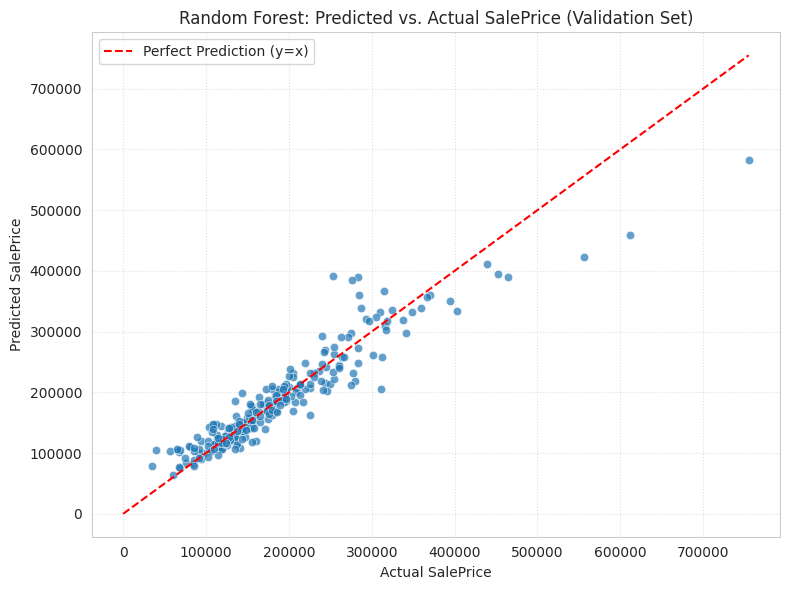

In [35]:
plt.figure(figsize=(8, 6))

# Scatter plot of Actual vs. Predicted values
sns.scatterplot(x=y_val, y=pred_rf, alpha=0.7)

# Add y=x reference line (perfect prediction)
max_val = max(y_val.max(), pred_rf.max())
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', label='Perfect Prediction (y=x)')

plt.title('Random Forest: Predicted vs. Actual SalePrice (Validation Set)')
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

### Q18. Which features are the most important according to your Random Forest model? How can you extract and visualize them?

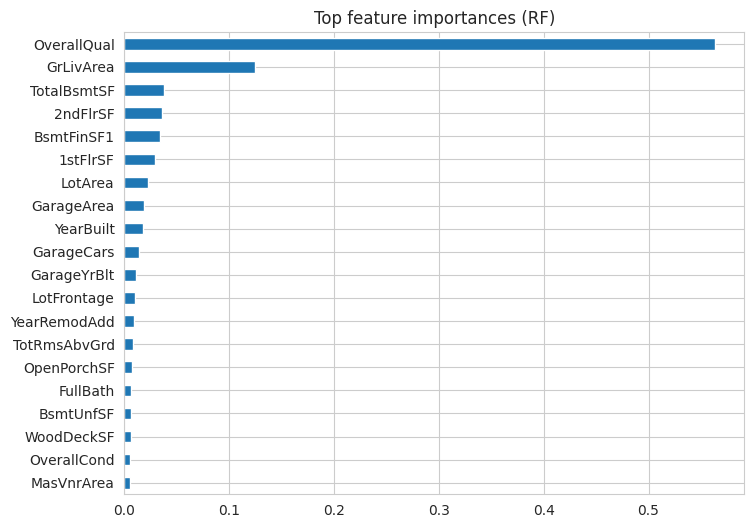

,0
OverallQual,0.563358
GrLivArea,0.124872
TotalBsmtSF,0.037870
2ndFlrSF,0.035974
BsmtFinSF1,0.034324
1stFlrSF,0.029546
LotArea,0.022368
GarageArea,0.018500
YearBuilt,0.017392
GarageCars,0.013553


In [ ]:
feat_imp = pd.Series(rf.feature_importances_, index=X_tr.columns).sort_values(ascending=False).head(20)
plt.figure(figsize=(8,6))
feat_imp.plot(kind='barh'); plt.gca().invert_yaxis(); plt.title('Top feature importances (RF)'); plt.show()
display(feat_imp)


## **Q19. Your model performs well on the training set but poorly on the test set. What are possible causes, and how can you address them?**
- Causes: overfitting, data leakage, inconsistent preprocessing, distribution shift.
- Fixes: regularization, cross-validation, proper pipelines, simpler models, feature selection, ensembling, check for leakage.


## Q20: Final checks before Kaggle submission
Checklist:
- Preprocessing consistency (same pipeline on train/test)
- No NaNs in features after preprocessing
- If training on log(SalePrice) → inverse transform with expm1
- Clip negative preds to >= 0
- Submission CSV must have columns: Id, SalePrice


In [ ]:
# Quick final-check pipeline (simple): numeric median impute + scale, low-cardinality OneHot, HGB regressor on log-target
X = train.drop(columns=['SalePrice']).copy()
y = train['SalePrice'].copy()

# Reload test data to ensure 'Id' column is present for submission
test_df_original = pd.read_csv(test_path)
test_ids = test_df_original['Id']

# Basic feature engineering again. Apply to both X and the (reloaded) test_df_original
for df_ in (X, test_df_original):
    df_['TotalLivingArea'] = df_.get('GrLivArea', 0).fillna(0) + df_.get('TotalBsmtSF', 0).fillna(0)
    df_['HouseAge'] = df_['YrSold'] - df_['YearBuilt']

# Drop Id from X (training features) and test_df_original (features for prediction)
if 'Id' in X.columns: X = X.drop(columns=['Id'])
# The test_df_original now becomes the 'test' for the pipeline
if 'Id' in test_df_original.columns: test_df_processed = test_df_original.drop(columns=['Id'])
else: test_df_processed = test_df_original.copy() # defensive copy if 'Id' was not there for some reason

# Simple preprocessing
num_feats = X.select_dtypes(include=[np.number]).columns.tolist()
cat_feats = X.select_dtypes(exclude=[np.number]).columns.tolist()
low_card = [c for c in cat_feats if X[c].nunique() <= 10]

numeric_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
low_card_transformer = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='Missing')), ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

preprocessor = ColumnTransformer([('num', numeric_transformer, num_feats), ('lowcat', low_card_transformer, low_card)], remainder='drop', sparse_threshold=0)

model = HistGradientBoostingRegressor(max_iter=200, learning_rate=0.1, random_state=42)
pipe = Pipeline([('pre', preprocessor), ('model', model)])

# Train on log-target
y_log = np.log1p(y)
pipe.fit(X, y_log)

# Predict and inverse-transform
preds_log = pipe.predict(test_df_processed) # Use the processed test dataframe
preds = np.expm1(preds_log)
preds = np.where(preds < 0, 0, preds)

submission = pd.DataFrame({'Id': test_ids, 'SalePrice': preds})
submission_path = 'submission.csv'
submission.to_csv(submission_path, index=False)
print('Saved submission to', submission_path)

Saved submission to submission.csv
